In [8]:
from Model import *
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
from statistics import mean

#get the data
split_ratio = 0.8
val_ratio = 0.2
data = pd.read_csv("Data/dataset_multilabel.csv", dtype = str)
train_df = data.sample(frac = split_ratio)
test_df = data.drop(train_df.index)
val_df = train_df.sample(frac = val_ratio)
train_df = train_df.drop(val_df.index)

train_dataset = QueueDataset(train_df)
test_dataset = QueueDataset(test_df)
val_dataset = QueueDataset(val_df)

#initialize the data loader 
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = True)

In [34]:
#model hyperparameters 
ntokens = 65536  # size of vocabulary
emsize = 240  # embedding dimension
d_hid = 240  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 3  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 8  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

#define the model 
device = "cpu"
transformer = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(transformer.parameters())

In [35]:
# train and validate the model
train_losses = []
train_f1 = []
val_losses = []
val_f1 = []
batch_num = []
for epoch in range(3):
    transformer.train()

    train_losses_per_100 = []
    train_f1_per_100 = []
    val_losses_per_100 = []
    val_f1_per_100 = []

    for i, data in enumerate(train_loader):
        #get the data
        queues, labels = data
        queues = queues.to(device)
        labels = labels.to(device)

        #forward pass
        optimizer.zero_grad()
        output = transformer(queues)
        loss = criterion(output, labels)

        #backward pass
        loss.backward()
        optimizer.step()

        #metrics
        f_score = F_score(output, labels)

        train_losses_per_100.append(loss.item())
        train_f1_per_100.append(f_score)
        if (i+1) % 100 == 0:
            print('epoch: {}, batch: {}, loss: {} f1 score:{}'.format(epoch + 1, i + 1, loss.item(), f_score))

            train_losses.append(np.array(train_losses_per_100).mean())
            train_f1.append(np.array(train_f1_per_100).mean())
            train_losses_per_100 = []
            train_f1_per_100 = []

            batch_num.append((i + 1) + (epoch) * (600))

            #validate the model
            transformer.eval()
            for i, data in enumerate(val_loader):
                queues, labels = data
                queues = queues.to(device)
                labels = labels.to(device)

                #forward pass
                output = transformer(queues)
                loss = criterion(output, labels)

                #metrics
                f_score = F_score(output, labels)

                val_losses_per_100.append(loss.item())
                val_f1_per_100.append(f_score)
            

            val_losses.append(np.array(val_losses_per_100).mean())
            val_f1.append(np.array(val_f1_per_100).mean())
            val_losses_per_100 = []
            val_f1_per_100 = []
            
            print('epoch: {}, validation loss: {} validation f1 score:{}'.format(epoch + 1, loss.item(), f_score))
            transformer.train()

epoch: 1, batch: 100, loss: 0.4878748059272766 f1 score:0.7744594812393188
epoch: 1, validation loss: 0.5152764320373535 validation f1 score:0.8194621205329895
epoch: 1, batch: 200, loss: 0.16819153726100922 f1 score:0.9174817204475403
epoch: 1, validation loss: 0.22186674177646637 validation f1 score:0.8909124135971069
epoch: 1, batch: 300, loss: 0.18239842355251312 f1 score:0.8967821002006531
epoch: 1, validation loss: 0.2152322381734848 validation f1 score:0.8837407827377319
epoch: 1, batch: 400, loss: 0.19242867827415466 f1 score:0.9116519093513489
epoch: 1, validation loss: 0.0896068885922432 validation f1 score:0.8916649222373962
epoch: 1, batch: 500, loss: 0.14030079543590546 f1 score:0.8643572926521301
epoch: 1, validation loss: 0.2403116226196289 validation f1 score:0.8715749382972717
epoch: 1, batch: 600, loss: 0.1396341472864151 f1 score:0.8850677609443665
epoch: 1, validation loss: 0.14551793038845062 validation f1 score:0.9035850167274475
epoch: 2, batch: 100, loss: 0.0903

/var/folders/5m/5bz8j_1n6bv7tpcnz6sjyc280000gn/T/ipykernel_39096/44023111.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/var/folders/5m/5bz8j_1n6bv7tpcnz6sjyc280000gn/T/ipykernel_39096/44023111.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  g.show()


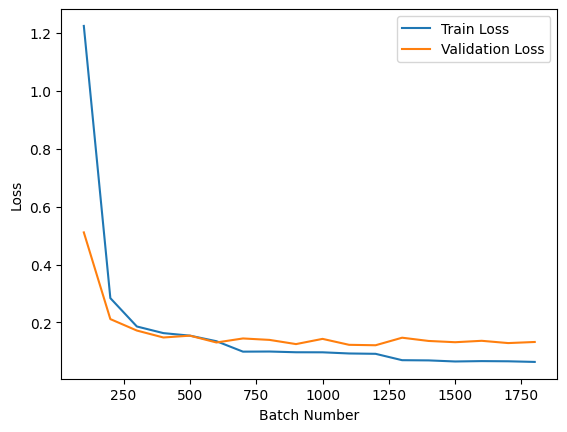

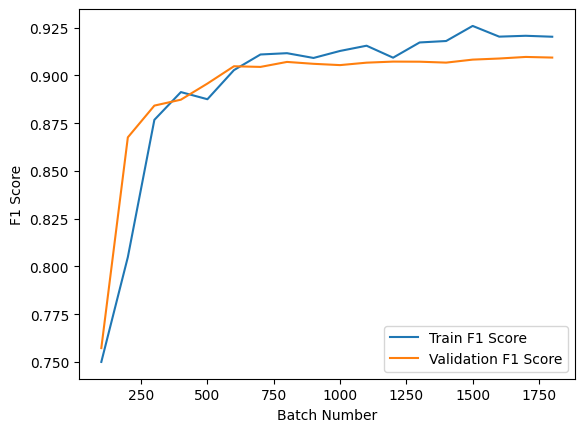

In [36]:
#plot the validation and training loss as well as f1 score
import matplotlib.pyplot as plt

f = plt.figure(1)
plt.plot(batch_num, train_losses, label = "Train Loss")
plt.plot(batch_num, val_losses, label = "Validation Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("240embeddings-3encoder-8heads-64tokensize-loss.png")
f.show()

g = plt.figure(2)
plt.plot(batch_num, train_f1, label = "Train F1 Score")
plt.plot(batch_num, val_f1, label = "Validation F1 Score")
plt.xlabel("Batch Number")
plt.ylabel("F1 Score")
plt.legend()
plt.savefig("240embeddings-3encoder-8heads-64tokensize-f1.png")
g.show()

#save the model
torch.save(transformer.state_dict(), "240embeddings-3encoder-8heads-64tokensize.pth")

In [42]:
'''
Run Inferences on Test Set. 

First Load the saved model from the file, then forward pass the test set on the model
'''

#load the model

#model hyperparameters 
ntokens = 65536  # size of vocabulary
emsize = 240  # embedding dimension
d_hid = 240  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 6  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 8  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

device = "cpu"
path = "TrainedModels/240embeddings-6encoder-8heads-64tokensize.pth"
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
model.load_state_dict(torch.load(path))

#run inferences on the test set
model.eval()
test_f1 = []
test_losses = []
for i, data in enumerate(test_loader):
    queues, labels = data
    queues = queues.to(device)
    labels = labels.to(device)

    #forward pass
    output = model(queues)
    loss = criterion(output, labels)

    #metrics
    f_score = F_score(output, labels)

    test_f1.append(f_score)
    test_losses.append(loss.item())

print("Test F1 Score: ", np.array(test_f1).mean())
print("Test Loss: ", np.array(test_losses).mean())


Test F1 Score:  0.7550359
Test Loss:  0.620840652368555
